In [1]:
import torch as th
import numpy as np
import pickle
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import os
import sys
import glob
sys.path.insert(0, '../../sample_scripts/')

from sample_scripts.sample_utils.inference_utils import to_tensor
from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

device = 'cuda:1'

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def get_cfg(self):
    from config.base_config import parse_args
    cfg_file_path = glob.glob("/home/mint/guided-diffusion/config/*/*", recursive=True)
    cfg_file_path = [cfg_path for cfg_path in cfg_file_path if f"/{self.cfg_name}" in cfg_path]    # Add /{}/ to achieve a case-sensitive of folder
    print("[#] Config Path : ", cfg_file_path)
    assert len(cfg_file_path) <= 1
    assert len(cfg_file_path) > 0
    cfg_file = cfg_file_path[0]
    cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})
    return cfg

In [2]:
ckpt_loader = ckpt_utils.CkptLoader(log_dir="UNetCond_Spatial_Hadamart_Tanh_Shape", cfg_name="UNetCond_Spatial_Hadamart_Tanh_Shape.yaml")
cfg = ckpt_loader.cfg
# Load dataset
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_='valid',
    cfg=cfg,
)

_, _, avg_dict = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_='train',
    cfg=cfg,
)

img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/valid/")
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg', '60182.jpg'])
dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=2,
                                    shuffle=False, num_workers=24)
                            
dat, model_kwargs = next(iter(subset_loader))

[#] Model Path :  ['/data/mint/model_logs_mount/v12/UNetCond_Spatial_Hadamart_Tanh_Shape/']
[#] Config Path :  ['/home/mint/guided-diffusion/config/EncLight_Spatial_Rendered_Face_Hadamart_clip/UNetCond_Spatial_Hadamart_Tanh_Shape.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/EncLight_Spatial_Rendered_Face_Hadamart_clip/UNetCond_Spatial_Hadamart_Tanh_Shape.yaml')



Loading deca params...: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb']
Remove keys :  []


Loading deca params...: 100%|██████████| 9/9 [00:39<00:00,  4.38s/it]


[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb']
Remove keys :  []


creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar


/home/mint/guided-diffusion/sample_scripts/sample_utils/params_utils.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'light':th.tensor(deca_params['light']).to(device).reshape(-1, 9, 3).float(),
/home/mint/miniconda3/envs/3dr_sampling_deca/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


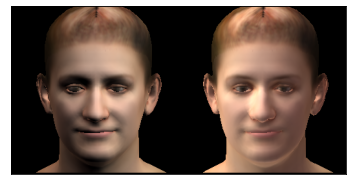

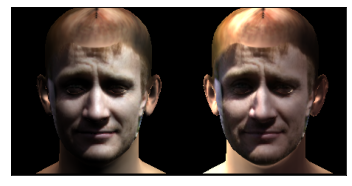

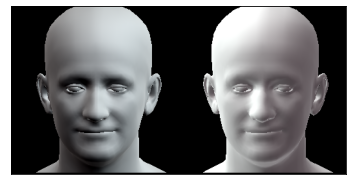

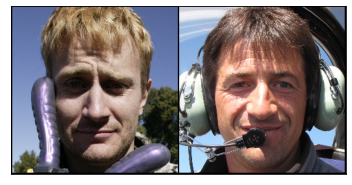

In [7]:
from importlib import reload
reload(params_utils)

rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=2, useTex=True, extractTex=True, deca_mode='', use_detail=True)
grid = torchvision.utils.make_grid(orig_visdict['rendered_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)

grid = torchvision.utils.make_grid(orig_visdict['rendered_images_uv_texture'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)

grid = torchvision.utils.make_grid(orig_visdict['shape_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)

grid = torchvision.utils.make_grid(model_kwargs['raw_image'].cpu())
show(grid/255.0)


In [4]:
mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
count = 0
for k, v in mask.items():
    count += len(v)
    print(f"{k} - {v.shape}")
    


eye_region - (751,)
neck - (253,)
left_eyeball - (546,)
right_eyeball - (546,)
right_ear - (588,)
right_eye_region - (287,)
forehead - (133,)
lips - (254,)
nose - (379,)
scalp - (489,)
boundary - (114,)
face - (1787,)
left_ear - (588,)
left_eye_region - (287,)
